In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.lines import Line2D
from shapely.geometry import Point
import geopandas
import seaborn as sns
from scipy import stats
from imblearn import under_sampling, over_sampling 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from src.data import DataLoaders
import shap

%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 111
random.seed(SEED)
np.random.seed(SEED)


In [2]:
ACSLoader = DataLoaders.ACSData('2016','block_group')
NFIRSLoader = DataLoaders.NFIRSData('block_group',ACSLoader.tot_pop)

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
ACS = ACSLoader.data
fires,top10 =  NFIRSLoader.fires, NFIRSLoader.top10

In [4]:
ACS = ACS.iloc[:,188:]

In [5]:
ACS

,inc_pct_poverty,race_pct_white,race_pct_whitenh,race_pct_nonwhite,race_pct_nonwhitenh,race_pct_amind,race_pct_black,race_pct_hisp,denom_age,age_under25_ma,age_25_64_ma,age_over65_ma,age_under25_fe,age_25_64_fe,age_over65_fe,age_pct_under25,age_pct_25_64,age_pct_over65,educ_no_school,educ_associates,educ_bachelors,educ_masters,educ_professional,educ_docterate,worked_past_12_mo_sum,worked_past_12_mo,did_not_work_past_12_mo_sum,did_not_work_past_12_mo,house_pct_family,house_pct_family_married,house_pct_family_male_hh,house_pct_family_female_hh,house_pct_non_family,house_pct_live_alone,house_pct_no_live_alone,house_pct_occupied,house_pct_vacant,house_pct_ownd_occupied,denom_house_room,house_pct_1_room,house_pct_2_room,house_pct_3_room,house_pct_4_room,house_pct_5_room,house_pct_6_room,house_pct_7_room,house_pct_8_room,house_pct_9_plus_room,denom_house_yr,denom_heat,heat_pct_utility_gas,heat_pct_bottled_tank_lpgas,heat_pct_electricity,heat_pct_fueloil_kerosene,heat_pct_coal,heat_pct_wood,heat_pct_solar,heat_pct_other,heat_pct_no_fuel,denom_plumb,house_pct_complete_plumb,house_pct_incomplete_plumb,denom_kitch,house_pct_complete_kitchen,house_pct_incomplete_kitchen,denom_house_mort,house_w_1_mort,house_w_2_mort,house_w_home_equity_loan,house_w_both_2_mort_and_loan,house_no_mort,educ_less_12th,educ_high_school,house_yr_pct_before_1960,house_yr_pct_after_2000,house_yr_pct_1960_2000,house_val_less_125K,house_val_125K_300K,house_val_300K_500K,house_val_more_500K
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
010010201001,0.191946,0.785235,0.763758,0.214765,0.236242,0.000000,0.214765,0.021477,745.0,135.0,211.0,10.0,136.0,236.0,17.0,0.363758,0.600000,0.036242,0.000000,0.031646,0.126582,0.048523,0.014768,0.033755,347.0,0.644981,191.0,0.355019,0.679577,0.394366,0.038732,0.246479,0.320423,0.221831,0.098592,1.000000,0.000000,0.602113,284.0,0.000000,0.000000,0.000000,0.126761,0.316901,0.257042,0.119718,0.077465,0.102113,284.0,284.0,0.492958,0.017606,0.489437,0.000000,0.000000,0.000000,0.0,0.000000,0.0,284.0,0.904930,0.095070,284.0,0.904930,0.095070,171.0,0.590643,0.000000,0.000000,0.0,0.409357,0.217300,0.527426,0.221831,0.193662,0.584507,0.380117,0.508772,0.467836,0.000000
010010201002,0.044269,0.856126,0.826877,0.143874,0.173123,0.000000,0.082213,0.029249,1265.0,247.0,324.0,68.0,194.0,355.0,77.0,0.348617,0.536759,0.114625,0.008495,0.041262,0.189320,0.143204,0.021845,0.010922,720.0,0.690979,322.0,0.309021,0.855263,0.679825,0.008772,0.166667,0.144737,0.127193,0.017544,0.976445,0.023555,0.831140,467.0,0.000000,0.000000,0.008565,0.036403,0.248394,0.141328,0.100642,0.211991,0.252677,467.0,456.0,0.554825,0.032895,0.412281,0.000000,0.000000,0.000000,0.0,0.000000,0.0,467.0,1.000000,0.000000,467.0,0.989293,0.010707,379.0,0.554090,0.010554,0.102902,0.0,0.332454,0.069175,0.515777,0.079229,0.085653,0.835118,0.237467,0.538259,0.627968,0.034301
010010202001,0.382199,0.376042,0.376042,0.623958,0.623958,0.000000,0.591667,0.013542,960.0,283.0,205.0,46.0,75.0,242.0,109.0,0.372917,0.465625,0.161458,0.014950,0.024917,0.089701,0.011628,0.014950,0.000000,358.0,0.490411,372.0,0.509589,0.632124,0.375648,0.015544,0.240933,0.367876,0.344560,0.023316,0.969849,0.030151,0.590674,398.0,0.000000,0.000000,0.095477,0.105528,0.251256,0.198492,0.150754,0.070352,0.128141,398.0,386.0,0.712435,0.000000,0.287565,0.000000,0.000000,0.000000,0.0,0.000000,0.0,398.0,1.000000,0.000000,398.0,1.000000,0.000000,228.0,0.653509,0.030702,0.000000,0.0,0.315789,0.186047,0.657807,0.135678,0.211055,0.653266,0.337719,0.394737,0.460526,0.030702
010010202002,0.111426,0.497573,0.488673,0.502427,0.511327,0.000000,0.461974,0.012136,1236.0,221.0,386.0,27.0,154.0,358.0,90.0,0.303398,0.601942,0.094660,0.008130,0.085947,0.131243,0.045296,0.010453,0.006969,726.0,0.690114,326.0,0.309886,0.632743,0.407080,0.019912,0.205752,0.367257,0.338496,0.028761,0.918699,0.081301,0.659292,492.0,0.000000,0.000000,0.034553,0.142276,0.323171,0.162602,0.245935,0.063008,0.028455,492.0,452

In [72]:
ACS['race_pct_black_or_amind'] = ACS.loc[:,'race_pct_black'] + ACS.loc[:,'race_pct_amind']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                   Pair Var 1              Pair Var 2  Corr Value
125            denom_house_yr             denom_kitch    1.000000
105          denom_house_room             denom_plumb    1.000000
124            denom_house_yr             denom_plumb    1.000000
106          denom_house_room             denom_kitch    1.000000
157               denom_plumb             denom_kitch    1.000000
..                        ...                     ...         ...
139      heat_pct_utility_gas    heat_pct_electricity   -0.728818
2              race_pct_white          race_pct_black   -0.807980
193  house_yr_pct_before_1960  house_yr_pct_1960_2000   -0.826182
183            house_w_1_mort           house_no_mort   -0.873961
89           house_pct_family    house_pct_live_alone   -0.909566

[65 rows x 3 columns]


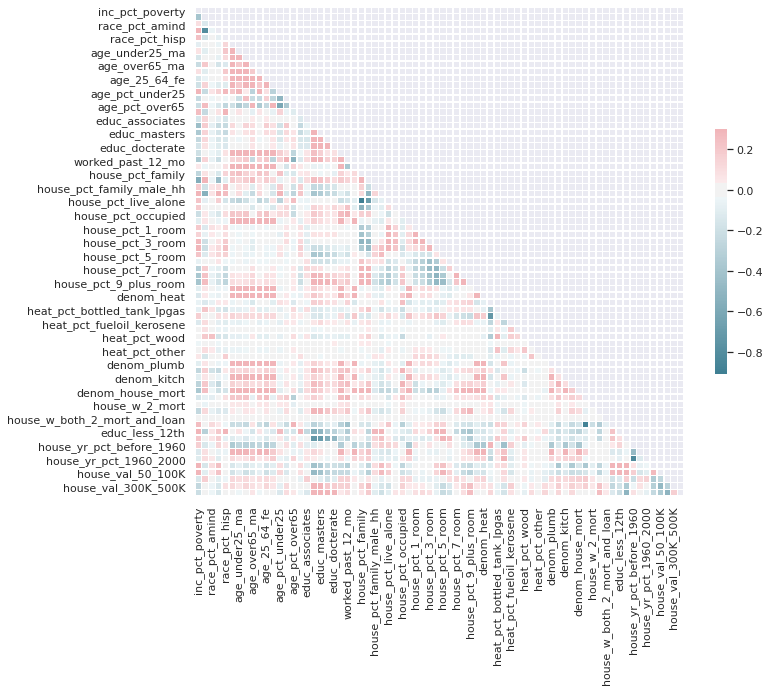

In [31]:
# Find correlated features in ACS dataset and identify the highly correlated relationships

# Create ACS correlation matrix
corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
print(corr_high.sort_values(by=['Corr Value'], ascending=False))

# From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
#ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_ownd_occupied',
#                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
#                           'house_pct_incomplete_kitchen', 'race_pct_whitenh'], axis=1) 

# Based on feature importance experiments, select features with consistence importance across annual predictions
#ACS = ACS[['house_yr_pct_earlier_1939', 'house_pct_occupied', 'house_pct_family_married', 'race_pct_black','race_pct_amind',
#          'worked_past_12_mo', 'heat_pct_fueloil_kerosene', 'educ_bachelors', 'house_pct_live_alone', 
#          'educ_some_col_no_grad', 'house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_175K_200K',
#           'house_val_200K_250K']]



In [54]:
ACS

,inc_pct_poverty,race_pct_white,race_pct_whitenh,race_pct_nonwhite,race_pct_nonwhitenh,race_pct_amind,race_pct_black,race_pct_hisp,denom_age,age_under25_ma,age_25_64_ma,age_over65_ma,age_under25_fe,age_25_64_fe,age_over65_fe,age_pct_under25,age_pct_25_64,age_pct_over65,educ_no_school,educ_associates,educ_bachelors,educ_masters,educ_professional,educ_docterate,worked_past_12_mo_sum,worked_past_12_mo,did_not_work_past_12_mo_sum,did_not_work_past_12_mo,house_pct_family,house_pct_family_married,house_pct_family_male_hh,house_pct_family_female_hh,house_pct_non_family,house_pct_live_alone,house_pct_no_live_alone,house_pct_occupied,house_pct_vacant,house_pct_ownd_occupied,denom_house_room,house_pct_1_room,house_pct_2_room,house_pct_3_room,house_pct_4_room,house_pct_5_room,house_pct_6_room,house_pct_7_room,house_pct_8_room,house_pct_9_plus_room,denom_house_yr,denom_heat,heat_pct_utility_gas,heat_pct_bottled_tank_lpgas,heat_pct_electricity,heat_pct_fueloil_kerosene,heat_pct_coal,heat_pct_wood,heat_pct_solar,heat_pct_other,heat_pct_no_fuel,denom_plumb,house_pct_complete_plumb,house_pct_incomplete_plumb,denom_kitch,house_pct_complete_kitchen,house_pct_incomplete_kitchen,denom_house_mort,house_w_1_mort,house_w_2_mort,house_w_home_equity_loan,house_w_both_2_mort_and_loan,house_no_mort,educ_less_12th,educ_high_school,house_yr_pct_before_1960,house_yr_pct_after_2000,house_yr_pct_1960_2000,house_val_less_125K,house_val_125K_300K,house_val_300K_500K,house_val_more_500K
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
010010201001,0.191946,0.785235,0.763758,0.214765,0.236242,0.000000,0.214765,0.021477,745.0,135.0,211.0,10.0,136.0,236.0,17.0,0.363758,0.600000,0.036242,0.000000,0.031646,0.126582,0.048523,0.014768,0.033755,347.0,0.644981,191.0,0.355019,0.679577,0.394366,0.038732,0.246479,0.320423,0.221831,0.098592,1.000000,0.000000,0.602113,284.0,0.000000,0.000000,0.000000,0.126761,0.316901,0.257042,0.119718,0.077465,0.102113,284.0,284.0,0.492958,0.017606,0.489437,0.000000,0.000000,0.000000,0.0,0.000000,0.0,284.0,0.904930,0.095070,284.0,0.904930,0.095070,171.0,0.590643,0.000000,0.000000,0.0,0.409357,0.217300,0.527426,0.221831,0.193662,0.584507,0.380117,0.508772,0.467836,0.000000
010010201002,0.044269,0.856126,0.826877,0.143874,0.173123,0.000000,0.082213,0.029249,1265.0,247.0,324.0,68.0,194.0,355.0,77.0,0.348617,0.536759,0.114625,0.008495,0.041262,0.189320,0.143204,0.021845,0.010922,720.0,0.690979,322.0,0.309021,0.855263,0.679825,0.008772,0.166667,0.144737,0.127193,0.017544,0.976445,0.023555,0.831140,467.0,0.000000,0.000000,0.008565,0.036403,0.248394,0.141328,0.100642,0.211991,0.252677,467.0,456.0,0.554825,0.032895,0.412281,0.000000,0.000000,0.000000,0.0,0.000000,0.0,467.0,1.000000,0.000000,467.0,0.989293,0.010707,379.0,0.554090,0.010554,0.102902,0.0,0.332454,0.069175,0.515777,0.079229,0.085653,0.835118,0.237467,0.538259,0.627968,0.034301
010010202001,0.382199,0.376042,0.376042,0.623958,0.623958,0.000000,0.591667,0.013542,960.0,283.0,205.0,46.0,75.0,242.0,109.0,0.372917,0.465625,0.161458,0.014950,0.024917,0.089701,0.011628,0.014950,0.000000,358.0,0.490411,372.0,0.509589,0.632124,0.375648,0.015544,0.240933,0.367876,0.344560,0.023316,0.969849,0.030151,0.590674,398.0,0.000000,0.000000,0.095477,0.105528,0.251256,0.198492,0.150754,0.070352,0.128141,398.0,386.0,0.712435,0.000000,0.287565,0.000000,0.000000,0.000000,0.0,0.000000,0.0,398.0,1.000000,0.000000,398.0,1.000000,0.000000,228.0,0.653509,0.030702,0.000000,0.0,0.315789,0.186047,0.657807,0.135678,0.211055,0.653266,0.337719,0.394737,0.460526,0.030702
010010202002,0.111426,0.497573,0.488673,0.502427,0.511327,0.000000,0.461974,0.012136,1236.0,221.0,386.0,27.0,154.0,358.0,90.0,0.303398,0.601942,0.094660,0.008130,0.085947,0.131243,0.045296,0.010453,0.006969,726.0,0.690114,326.0,0.309886,0.632743,0.407080,0.019912,0.205752,0.367257,0.338496,0.028761,0.918699,0.081301,0.659292,492.0,0.000000,0.000000,0.034553,0.142276,0.323171,0.162602,0.245935,0.063008,0.028455,492.0,452

In [89]:
ACS_reduced = ACS.copy()
#ACS_reduced = ACS_reduced[['did_not_work_past_12_mo',
#          'heat_pct_fueloil_kerosene', 'heat_pct_bottled_tank_lpgas', 'house_pct_live_alone', 
#           'inc_pct_poverty', 'house_w_home_equity_loan','age_pct_over65',
#           'heat_pct_wood','educ_less_12th']]


ACS_reduced = ACS_reduced[['race_pct_nonwhitenh','race_pct_black_or_amind']]


In [81]:
ACS_reduced

,did_not_work_past_12_mo,race_pct_black_or_amind,race_pct_nonwhitenh,heat_pct_fueloil_kerosene,heat_pct_bottled_tank_lpgas,house_pct_family_married,house_pct_live_alone,inc_pct_poverty,house_w_home_equity_loan,age_pct_over65,heat_pct_wood,educ_less_12th
GEOID,,,,,,,,,,,,
010010201001,0.355019,0.214765,0.236242,0.000000,0.017606,0.394366,0.221831,0.191946,0.000000,0.036242,0.000000,0.217300
010010201002,0.309021,0.082213,0.173123,0.000000,0.032895,0.679825,0.127193,0.044269,0.102902,0.114625,0.000000,0.069175
010010202001,0.509589,0.591667,0.623958,0.000000,0.000000,0.375648,0.344560,0.382199,0.000000,0.161458,0.000000,0.186047
010010202002,0.309886,0.461974,0.511327,0.000000,0.019912,0.407080,0.338496,0.111426,0.097315,0.094660,0.000000,0.169570
010010203001,0.294054,0.227157,0.373519,0.000000,0.000000,0.527913,0.276699,0.042301,0.067847,0.134095,0.000000,0.098301
...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,0.301663,0.000000,0.070693,0.000000,0.249267,0.492669,0.324047,0.094029,0.058252,0.175704,0.049853,0.051971
560459511002,0.288010,0.014547,0.081358,0.021448,0.659517,0.651475,0.258713,0.062579,0.009375,0.215517,0.116622,0.092580
560459513001,0.232123,0.000000,0.000000,0.000000,0.013384,0.516252,0.330784,0.261512,0.000000,0.076455,0.091778,0.046392


In [53]:
ACS_reduced

,worked_past_12_mo_sum,house_w_both_2_mort_and_loan,house_pct_family_married,race_pct_black,race_pct_amind,heat_pct_fueloil_kerosene,heat_pct_bottled_tank_lpgas,house_pct_live_alone,inc_pct_poverty,house_w_home_equity_loan,house_val_less_50K,house_val_more_500K,heat_pct_wood,age_over65_ma,educ_less_12th
GEOID,,,,,,,,,,,,,,,
010010201001,347.0,0.0,0.394366,0.214765,0.000000,0.000000,0.017606,0.221831,0.191946,0.000000,0.152047,0.000000,0.000000,10.0,0.217300
010010201002,720.0,0.0,0.679825,0.082213,0.000000,0.000000,0.032895,0.127193,0.044269,0.102902,0.100264,0.034301,0.000000,68.0,0.069175
010010202001,358.0,0.0,0.375648,0.591667,0.000000,0.000000,0.000000,0.344560,0.382199,0.000000,0.171053,0.030702,0.000000,46.0,0.186047
010010202002,726.0,0.0,0.407080,0.461974,0.000000,0.000000,0.019912,0.338496,0.111426,0.097315,0.053691,0.000000,0.000000,27.0,0.169570
010010203001,1306.0,0.0,0.527913,0.217851,0.009306,0.000000,0.000000,0.276699,0.042301,0.067847,0.057522,0.000000,0.000000,114.0,0.098301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,882.0,0.0,0.492669,0.000000,0.000000,0.000000,0.249267,0.324047,0.094029,0.058252,0.089320,0.038835,0.049853,163.0,0.051971
560459511002,1152.0,0.0,0.651475,0.009698,0.004849,0.021448,0.659517,0.258713,0.062579,0.009375,0.123438,0.039062,0.116622,209.0,0.092580
560459513001,698.0,0.0,0.516252,0.000000,0.000000,0.000000,0.013384,0.330784,0.261512,0.000000,0.229282,0.000000,0.091778,25.0,0.046392


In [7]:
# Extract GEOIDs of census blocks that were not present in the nfirs dataset
missing_GEOIDS_df = ACS[~ACS.index.isin(nfirs.index.tolist())]
missing_GEOIDS=set(missing_GEOIDS_df.index)

## Adjust total fires per year by the population counts

# Creates dataframe that shows the number of fires in each census block each year
fires =  pd.crosstab(nfirs.index,nfirs['year'])
fires.index.rename('GEOID',inplace = True)

# Grab total population values pulled from ACS dataframe and assign to each census block in NFIRS dataframe
fires = fires.merge(tot_pop, how = 'left', left_index = True, right_index = True)

# Remove resulting infinity values and zeros following merge 
# note: We keep resulting NA's as NA's to show gaps in data collection 
# use NA tolerant algo or change or add line to drop all rows with NAs
fires.replace([np.inf, -np.inf,0], np.nan,inplace = True)

# drop rows with low population count
fires = fires[fires['tot_population'] >= 50 ] 

# population adjustment
min_year,max_year = nfirs['year'].min(), nfirs['year'].max()
fires.loc[:,min_year:max_year] = fires.loc[:,min_year:max_year].div(fires['tot_population'], axis = 'index') * 1000

# remove population
fires.drop('tot_population',axis = 1, inplace = True)

# view fires by year across geoids; displays additional information regarding # of fires in higher percentile categories
fires.describe(percentiles=[.75, .85, .9 ,.95, .99])

# define variables to indicate census blocks in the top 10% percent of fire risk scores
top10 = fires > fires.quantile(.9)


In [8]:
pd.crosstab(nfirs.index,nfirs['year'])

year,2009,2010,2011,2012,2013,2014,2015,2016
row_0,,,,,,,,
010010201001,1,2,0,0,0,0,0,1
010010201002,2,1,0,2,1,0,2,1
010010202001,1,0,3,0,1,1,1,1
010010202002,3,3,3,1,1,0,1,0
010010203001,2,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...
560459511002,1,0,0,0,0,0,1,0
560459513001,1,0,1,0,1,1,0,0
560459513002,0,0,1,0,0,1,0,0


In [9]:
fires

,2009,2010,2011,2012,2013,2014,2015,2016
GEOID,,,,,,,,
010010201001,1.445087,2.890173,NaN,NaN,NaN,NaN,NaN,1.445087
010010201002,1.734605,0.867303,NaN,1.734605,0.867303,NaN,1.734605,0.867303
010010202001,0.985222,NaN,2.955665,NaN,0.985222,0.985222,0.985222,0.985222
010010202002,3.134796,3.134796,3.134796,1.044932,1.044932,NaN,1.044932,NaN
010010203001,0.782779,1.174168,0.782779,0.391389,1.174168,0.391389,0.391389,0.782779
...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.476015
560459511002,0.590667,NaN,NaN,NaN,NaN,NaN,0.590667,NaN
560459513001,0.901713,NaN,0.901713,NaN,0.901713,0.901713,NaN,NaN


In [6]:
# function to create histogram of with # of fires on x-axis and # of census blocks on y-axis
def plotFires(df):

    figsize = (20, 16)
    cols = 4
    rows = 2
    f, axs = plt.subplots(cols,rows,figsize= figsize)


    cases = df.columns.to_list()
    for  case in enumerate(cases):
        ax = plt.subplot(cols,rows,case[0]+1)
        ax.set_title('All Fires {}'.format(str(case[1])) )
        plt.hist(df[case[1]],bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,20,40,80,100])
        

In [7]:
# Function to upsample or downsample our dataframe features if we have unbalanced classes

def resample_df(X,y,upsample=True,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    # Add Class feature to dataframe equal to our existing dependent variable
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    

    if upsample:      
    
        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0], 
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        #print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       #df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        #print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      #df_major_resampled.shape[0]))


    
    
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1)
    return X_out , y_out

In [8]:
def munge_dataset(top10,fires,ACS,n_years,test_year):    
    years = top10.columns
    test_loc = years.get_loc(str(test_year))
    
      # convert format for consistent output
    X =  fires.iloc[:,test_loc-n_years:test_loc].copy()
    
    #X.columns = ['year-{}'.format(n_years-1 - year) for year in range(n_years-1)]

    #sm = np.nansum(X, axis = 1 )
    #mu = np.nanmean(X, axis = 1)
    mx = np.nanmax(X, axis =1)
    md = np.nanmedian(X,axis =1 )
    X['Median'] = md  
    #X['Sum']  = sm
    #X['Mean'] = mu
    X['Max']  = mx
    
    
    
   
    
    y  = top10.iloc[:,test_loc]
    
   



    # merge in ACS Data into X unless NFIRS-Only model
    out_fires = []
    if not ACS.empty:
        
        # save copy for manual validation
        out_fires = X.copy().merge(ACS, how ='left',left_index = True, right_index = True)
        
        X=X[['Max','Median']] # drop all other NFIRS columns that have low feature importance scores
        X = X.merge(ACS, how ='left',left_index = True, right_index = True)
        
        
        
        

    
    
    return X,y,out_fires 

In [101]:
# Function to train model that predicts whether each census block is in the top 10% percent of fire risk scores
def train_model(top10,fires, ACS = pd.DataFrame(), n_years = 5, modeltype='LogisticRegression',test_year=2016, seed = SEED):
    from scipy.stats import zscore
    
    predict = False 
    # Define model types & parameters 
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced',
                                   max_iter = 1000)

        
    elif modeltype =='BalBagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                          n_estimators=80, sampling_strategy='auto',
                                          random_state=0,
                                          n_jobs = -1)
        
    elif modeltype =='BalRF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=80, sampling_strategy='auto',
                                               max_depth=10, random_state=0,
                                              max_features=None, min_samples_leaf=40,
                                              n_jobs = -1)

    elif modeltype =='Bagged':
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    n_estimators=40,
                                    random_state=0)
    
    elif modeltype =='RF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=60,
                                          warm_start = False,
                                          max_depth = 10,
                                        random_state = 0)
        
        
    elif modeltype =='XGBoost':
        from xgboost import XGBClassifier 
        model = XGBClassifier( n_estimators=60,
                    max_depth=10,
                    random_state=0,
                    max_features = None,
                    n_jobs = -1, 
                    seed = SEED )
        
    
    
    # Create framework to predict whether a given census block has a fire risk score in the 90th percentile 
            # based on the specific number of previous years' data
        
    years = top10.columns
    Model_Input = None
    Model_Predictions = None
    Model_Prediction_Probs = None
    Model_Actual = None
    
    
    if test_year == 'Current':
        predict = True 
        test_year = fires.columns[-1]
               
    # each model will train on 4 years of data to predict the locations subsequent year with highest fire risk 
    # model will train predicting 1 year and then test model accuracy by predicting the next year 
    
    # for example: 
    
    #  Train 
    # predict 2016 using 2015-2012 data 
    #
    #
    #  Test
    # predict 2017 using 2016-2015 data  
   
    

    X_train, y_train,_ = munge_dataset(top10,fires,ACS,n_years,test_year-1)
    
    X_test, y_test,Input = munge_dataset(top10,fires,ACS,n_years,test_year)
    
    # Note: `Input` is used for manual data validation to ensure munging performed correctly 
     

    # Create 80/20 training/testing set split
    #X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )

    # Perform resampling if data classes are unbalanced
    X_train, y_train = resample_df(X_train,y_train,upsample = False)



    # Standardize features by removing the mean and scaling to unit variance

    # scaler = preprocessing.StandardScaler().fit(X_train)
    # X_train= scaler.transform(X_train)
    # X_test = scaler.transform(X_test)


    # Fit model to training set

    print('Predicting {}:'.format(str(test_year)) )
    model = model.fit(X_train,y_train)


    # Calculate training set performance

    #train_prediction_probs = model.predict_proba(X_train)
    #train_predictions = model.predict(X_train)
    #print (confusion_matrix(y_train, train_predictions))
    #print (roc_auc_score(y_train, train_prediction_probs[:,1]))


    # Calculate test set performance

    test_prediction_probs = model.predict_proba(X_test)
    test_predictions = model.predict(X_test)
    #Model_Predictions = pd.Series(test_predictions)
    #Model_Prediction_Probs = pd.Series(test_prediction_probs[:,[1]].flatten())
    print (confusion_matrix(y_test, test_predictions))
    print (roc_auc_score(y_test, test_prediction_probs[:,1]))
    print (classification_report(y_test,test_predictions))
    print (log_loss(y_test,test_predictions))


    #Calculate feature importance for each model

    if modeltype=="LogisticRegression":
        feature_importance = {}
        for coef, feat in zip(abs(model.coef_[0]),X_test.columns.tolist()):
            feature_importance[feat] = coef
        print("Feature ranking:")
        print (feature_importance)
    else:
        if modeltype=="RF" or modeltype=="BalRF":
            importances = model.feature_importances_
        elif modeltype=="Bagged":
            importances = np.mean([model.estimators_[i].feature_importances_ for i 
                           in range(len(model.estimators_))], axis=0)
        elif modeltype=="BalBagged":
            importances = np.mean([model.estimators_[i].steps[1][1].feature_importances_ for i 
                           in range(len(model.estimators_))], axis=0)
        elif modeltype =='XGBoost':
                importances = model.feature_importances_

        indices = np.argsort(importances)[::-1]
        print("Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))
     
    
                                                                # to fix 
    return model,X_test,y_test,Input,test_predictions,test_prediction_probs[:,1],test_predictions
        


In [53]:
ACS_reduced

,worked_past_12_mo_sum,house_pct_family_married,race_pct_white,race_pct_black,race_pct_hisp,heat_pct_fueloil_kerosene,heat_pct_bottled_tank_lpgas,house_pct_live_alone,inc_pct_poverty,house_w_home_equity_loan,heat_pct_wood,age_over65_ma,educ_less_12th
GEOID,,,,,,,,,,,,,
010010201001,347.0,0.394366,0.785235,0.214765,0.021477,0.000000,0.017606,0.221831,0.191946,0.000000,0.000000,10.0,0.217300
010010201002,720.0,0.679825,0.856126,0.082213,0.029249,0.000000,0.032895,0.127193,0.044269,0.102902,0.000000,68.0,0.069175
010010202001,358.0,0.375648,0.376042,0.591667,0.013542,0.000000,0.000000,0.344560,0.382199,0.000000,0.000000,46.0,0.186047
010010202002,726.0,0.407080,0.497573,0.461974,0.012136,0.000000,0.019912,0.338496,0.111426,0.097315,0.000000,27.0,0.169570
010010203001,1306.0,0.527913,0.626481,0.217851,0.096447,0.000000,0.000000,0.276699,0.042301,0.067847,0.000000,114.0,0.098301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,882.0,0.492669,0.950583,0.000000,0.021277,0.000000,0.249267,0.324047,0.094029,0.058252,0.049853,163.0,0.051971
560459511002,1152.0,0.651475,0.935884,0.009698,0.018858,0.021448,0.659517,0.258713,0.062579,0.009375,0.116622,209.0,0.092580
560459513001,698.0,0.516252,1.000000,0.000000,0.000000,0.000000,0.013384,0.330784,0.261512,0.000000,0.091778,25.0,0.046392


In [100]:
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl,X_test,y_test,Input,Predictions,Prediction_Probs,Actuals =train_model(top10.loc[:,'2009':'2017'],fires,ACS = ACS,n_years=5,test_year = 2017, modeltype='XGBoost')

All-NaN axis encountered
All-NaN slice encountered


Predicting 2017:
[[148878  42583]
 [  2385   8937]]
0.8684795633903224
              precision    recall  f1-score   support

       False       0.98      0.78      0.87    191461
        True       0.17      0.79      0.28     11322

    accuracy                           0.78    202783
   macro avg       0.58      0.78      0.58    202783
weighted avg       0.94      0.78      0.84    202783

7.659289714540734
Feature ranking:
1. Max (0.132440)
2. Median (0.036925)
3. worked_past_12_mo_sum (0.031668)
4. heat_pct_fueloil_kerosene (0.023874)
5. denom_age (0.022184)
6. house_val_more_500K (0.016293)
7. age_25_64_fe (0.015398)
8. race_pct_black (0.015226)
9. house_pct_2_room (0.013726)
10. house_pct_family (0.013655)
11. heat_pct_bottled_tank_lpgas (0.013466)
12. denom_house_mort (0.013455)
13. house_val_less_125K (0.013331)
14. heat_pct_no_fuel (0.013046)
15. heat_pct_wood (0.012810)
16. race_pct_black_or_amind (0.012485)
17. heat_pct_utility_gas (0.012254)
18. denom_heat (0.012234)
19.

In [57]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_test,y_test,approximate = True)

In [ ]:
shap.summary_plot(shap_values,X_test, feature_names = X_test.columns)

In [102]:
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl,X_test,est,Input,Predictions,Prediction_Probs,Actuals  =train_model(top10.loc[:,'2009':'2017'],fires,ACS = ACS_reduced,n_years=5,test_year = 2017, modeltype='XGBoost')

All-NaN axis encountered
All-NaN slice encountered


Predicting 2017:
[[146487  44974]
 [  2524   8798]]
0.8561510810575818
              precision    recall  f1-score   support

       False       0.98      0.77      0.86    191461
        True       0.16      0.78      0.27     11322

    accuracy                           0.77    202783
   macro avg       0.57      0.77      0.57    202783
weighted avg       0.94      0.77      0.83    202783

8.090218422157148
Feature ranking:


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [91]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_test,y_test,approximate = True)

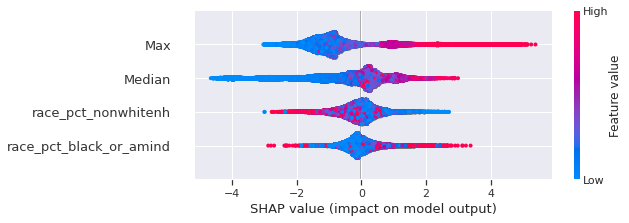

In [92]:
shap.summary_plot(shap_values,X_test, feature_names = X_test.columns)

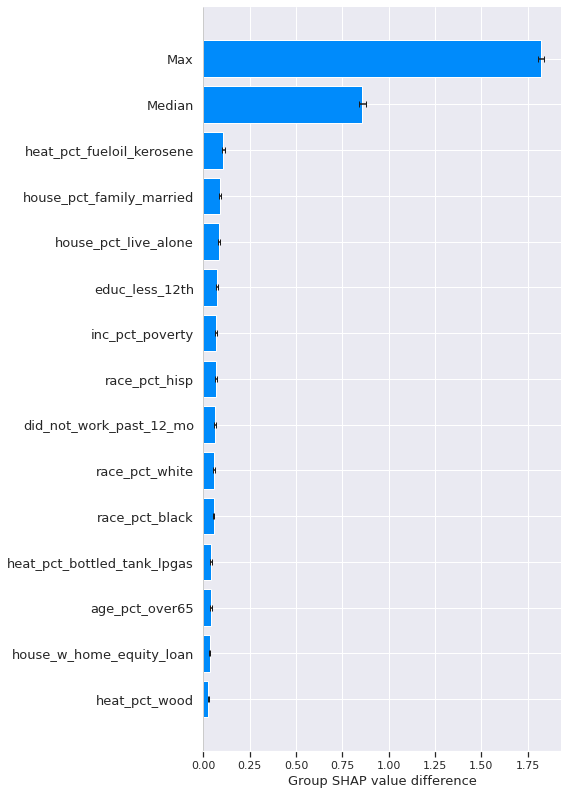

In [63]:
shap.group_difference_plot(shap_values,y_test,feature_names = X_test.columns)

In [167]:
Input['True_Labels']=Actuals
Input['Predicted_Labels']=Predictions
Input['Predicted_Probs']=Prediction_Probs
Input['GEOID']=list(Input.index)


In [ ]:

missing_GEOIDS_df_2=missing_GEOIDS_df[['house_yr_pct_earlier_1939', 'house_pct_occupied',
       'house_pct_family_married', 'race_pct_black', 'worked_past_12_mo',
       'heat_pct_fueloil_kerosene', 'educ_bachelors', 'house_pct_live_alone',
       'educ_some_col_no_grad', 'house_pct_ownd_occupied',
       'house_w_home_equity_loan', 'house_val_175K_200K',
       'house_val_200K_250K']]
missing_GEOIDS_df_2['True_Labels']=0
missing_GEOIDS_df_2['Predicted_Labels']=0
missing_GEOIDS_df_2['Predicted_Probs']=0
missing_GEOIDS_df_2['GEOID']=list(missing_GEOIDS_df_2.index)

New_Input=pd.concat([Input,missing_GEOIDS_df_2],ignore_index=False)
New_Input['GEOID']  = '#_' + New_Input['GEOID']
New_Input.set_index('GEOID',inplace = True)



In [170]:
New_Input.to_csv( out_path / 'PropensityBlockModel.csv')

In [171]:
New_Input.index.str[2:4].value_counts()

06    23044
48    15698
36    15173
12    11331
42     9697
17     9674
39     9212
26     8114
34     6273
37     6080
13     5487
51     5277
25     4962
18     4801
53     4745
29     4490
55     4468
04     4140
27     4104
47     4099
24     3887
08     3504
22     3434
01     3424
21     3254
45     3016
40     2955
19     2623
41     2621
09     2573
20     2330
28     2149
05     2140
32     1819
49     1677
31     1624
54     1591
35     1443
23     1077
16      960
33      919
30      839
15      811
44      808
46      651
10      568
38      568
02      528
50      520
11      447
56      409
NA        1
Name: GEOID, dtype: int64

In [13]:
# Function to visualize relative feature importance for trained Logistic Regression models
def plot_LR_feat_importance(model):
    # Calculate and store relative importance of model features
    feature_importance = {}
    for coef, feat in zip(abs(model.coef_[0]),X_test.columns.tolist()):
        feature_importance[feat] = coef
    data_to_plot = pd.DataFrame.from_dict(features,orient ='index').reset_index()
    data_to_plot.columns = ['Variables','Importance Coefficients']
    data_to_plot = data_to_plot.sort_values('Importance Coefficients', ascending=False )
    data_to_plot = data_to_plot[0:10]

    plt.figure(figsize=(16, 8))
    sns.barplot(
        x='Variables', y='Importance Coefficients',
        data=data_to_plot, palette='Blues_r')
    plt.xticks(
        range(len(data_to_plot)),
        data_to_plot['Variables'], rotation='45', size=10)
    plt.xlabel('Variables', fontsize=30)
    plt.ylabel('Coeff', fontsize=30)
    plt.tight_layout()
    plt.show()
    

In [28]:
# Display list of relative feature importance for RF models
def rf_feat_importance(model, num_feats_to_display):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(num_feats_to_display):
        print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))

In [ ]:
# Function to visualize example tree from random forest (only functional if model max_depth<=5)
def plot_rf_tree(model):
    estimator = model.estimators_[1]
    from sklearn import tree
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
    tree.plot_tree(estimator,
               feature_names = X_test.columns, 
               class_names=y_test.index.name,
               filled = True);
    fig.savefig('rf_individualtree.png')

In [38]:
def process_data(X,y, test_size=0.2, seed=SEED):
    
    from scipy.stats import zscore
    
    
    X = np.log(X +1)
    y = np.log(y+1)
    
    print (X.shape)
   # rename features and add new features
    X.columns = ['year-{}'.format(year[0]+1) for year in enumerate(X.columns)]
    X.columns
    X['Sum'] = np.sum(X, axis = 1 )
    X['mean']= np.mean(X, axis = 1)
    X['median'] = np.median(x, axis = 1)
    
    
    X = zscore(X.astype(float), axis=0)
    
    
 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    return X_train, X_test, y_train, y_test